In [ ]:
# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
# 2. Load and Preprocess the Data
data = pd.read_csv('HR/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Convert date columns to datetime format
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')


In [ ]:
# Drop columns that are not useful for prediction
data = data.drop(columns=['Facility Name', 'Facility ID', 'Footnote'])


In [ ]:
# Fill missing values in numeric columns with the median
for col in ['Number of Discharges', 'Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate']:
    data[col] = data[col].fillna(data[col].median())


In [ ]:
# Convert 'Number of Readmissions' to numeric and fill NaNs
data['Number of Readmissions'] = pd.to_numeric(data['Number of Readmissions'], errors='coerce')
data['Number of Readmissions'] = data['Number of Readmissions'].fillna(data['Number of Readmissions'].median())


In [ ]:
# Encode categorical columns
data['State'] = LabelEncoder().fit_transform(data['State'])
data['Measure Name'] = LabelEncoder().fit_transform(data['Measure Name'])


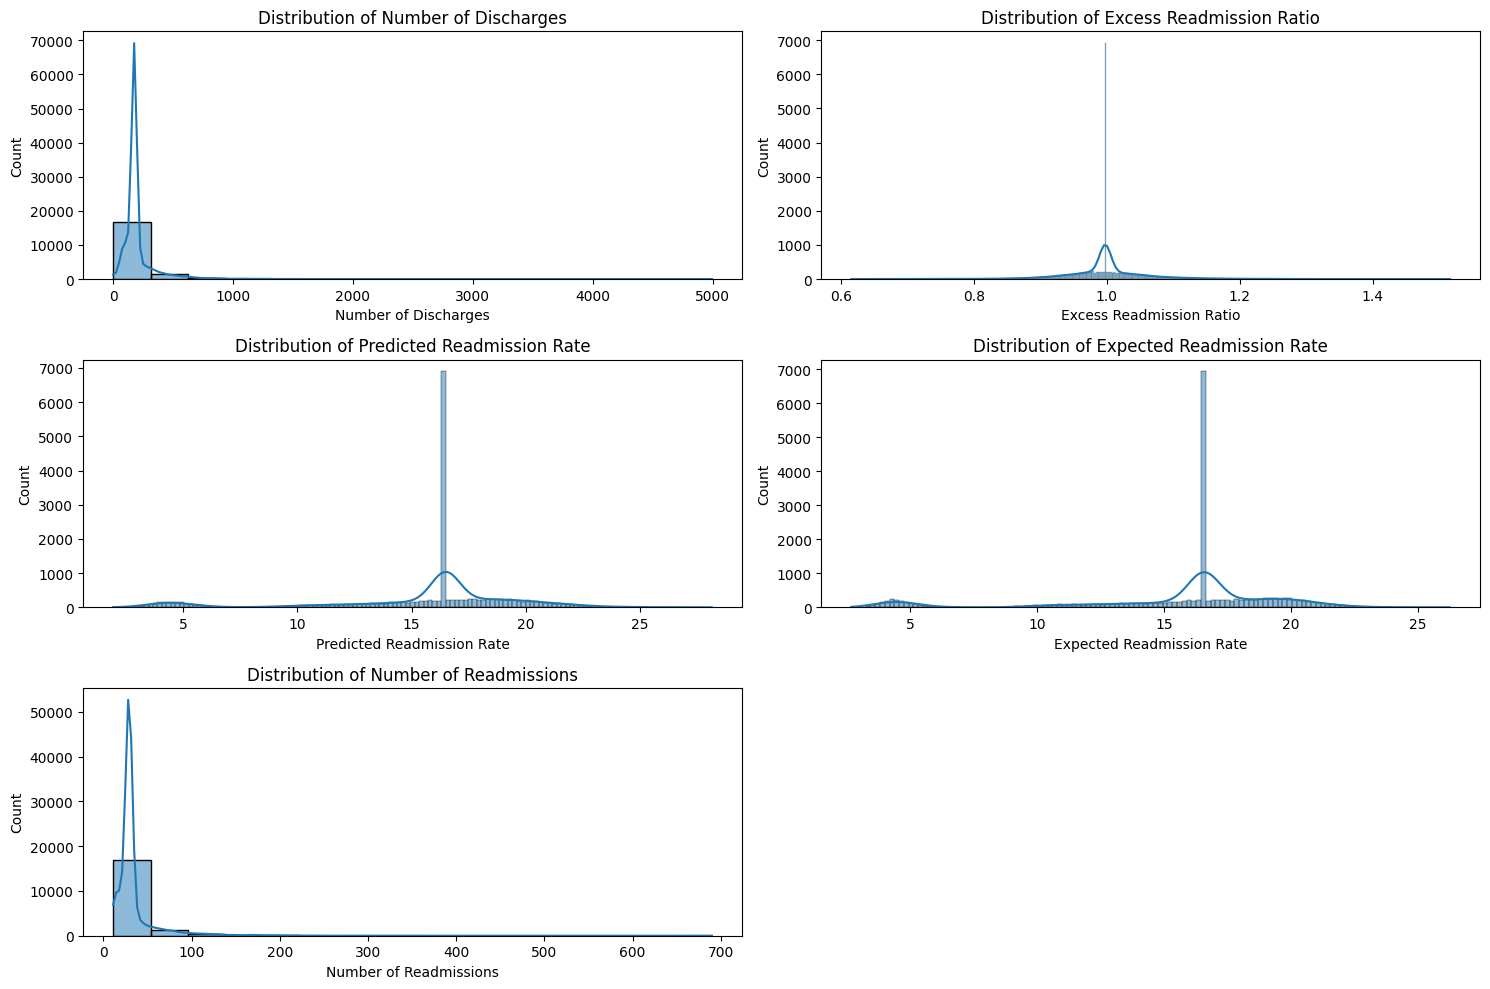

In [ ]:
# 3. Exploratory Data Analysis (EDA)
plt.figure(figsize=(15, 10))
numeric_features = ['Number of Discharges', 'Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate', 'Number of Readmissions']
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

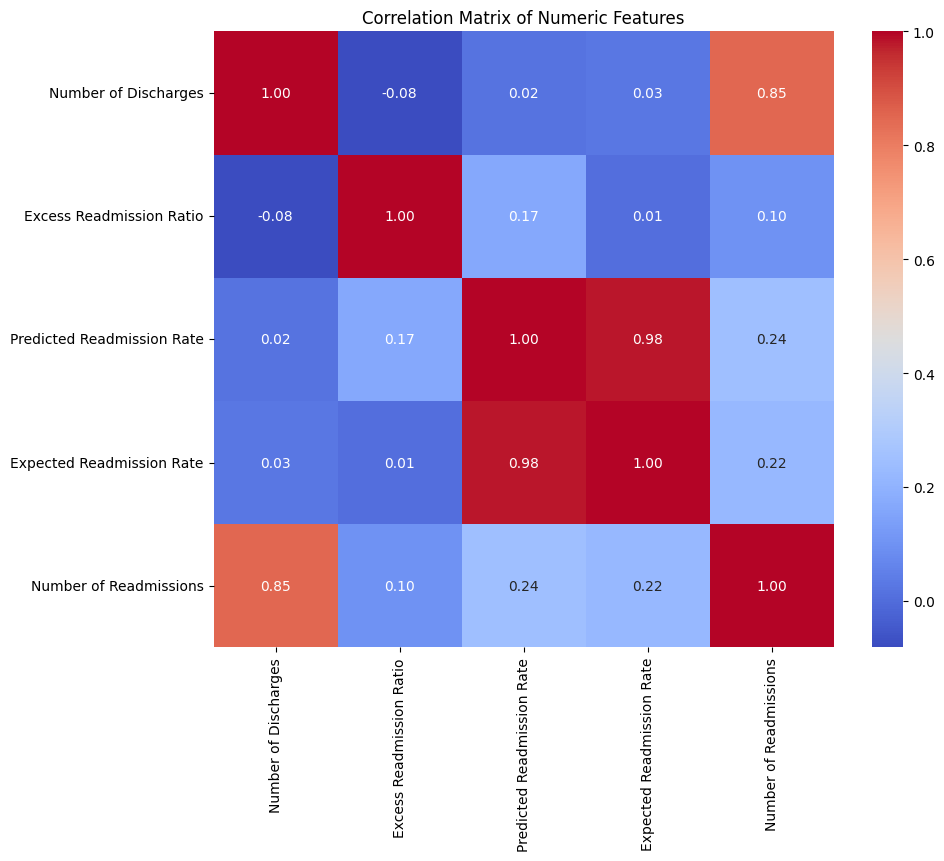

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = data[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [ ]:
# 4. Split Data into Training and Testing Sets
X = data.drop(columns=['Excess Readmission Ratio'])  # Assuming 'Excess Readmission Ratio' as target variable
y = data['Excess Readmission Ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Drop date columns, as they won't be useful for model training
X = data.drop(columns=['Excess Readmission Ratio', 'Start Date', 'End Date'])  # Drop 'Excess Readmission Ratio' as it's the target
y = data['Excess Readmission Ratio']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# 5. Model Building and Training

# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)

In [ ]:
# XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# CatBoost Regressor
catboost = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42)
catboost.fit(X_train, y_train)

In [ ]:
# Ensemble Model with Voting Regressor
ensemble = VotingRegressor([('mlp', mlp), ('xgb', xgb), ('catboost', catboost)])
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('mlp',
                             MLPRegressor(hidden_layer_sizes=(64, 64),
                                          max_iter=1000, random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, g...
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f208b620250>)])

In [ ]:
# 6. Model Evaluation Function
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} Evaluation Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R^2): {r2:.4f}\n")

In [ ]:
# Evaluate each model
models = {
    'MLP Regressor': mlp,
    'XGBoost Regressor': xgb,
    'CatBoost Regressor': catboost,
    'Ensemble Model': ensemble
}

for name, model in models.items():
    evaluate_model(model, X_test, y_test, model_name=name)

MLP Regressor Evaluation Metrics:
  Mean Squared Error (MSE): 0.0001
  Root Mean Squared Error (RMSE): 0.0115
  Mean Absolute Error (MAE): 0.0073
  R-squared (R^2): 0.9644

XGBoost Regressor Evaluation Metrics:
  Mean Squared Error (MSE): 0.0001
  Root Mean Squared Error (RMSE): 0.0105
  Mean Absolute Error (MAE): 0.0049
  R-squared (R^2): 0.9699

CatBoost Regressor Evaluation Metrics:
  Mean Squared Error (MSE): 0.0003
  Root Mean Squared Error (RMSE): 0.0175
  Mean Absolute Error (MAE): 0.0097
  R-squared (R^2): 0.9174

Ensemble Model Evaluation Metrics:
  Mean Squared Error (MSE): 0.0001
  Root Mean Squared Error (RMSE): 0.0091
  Mean Absolute Error (MAE): 0.0051
  R-squared (R^2): 0.9775



In [ ]:
# Modify the MLP model to have fewer layers and neurons
mlp = MLPRegressor(hidden_layer_sizes=(32,), max_iter=500, random_state=42)

# Reduce the number of estimators in XGBoost and increase learning rate
xgb = XGBRegressor(n_estimators=50, learning_rate=0.3, random_state=42)

# Reduce the number of iterations in CatBoost and increase learning rate
catboost = CatBoostRegressor(iterations=50, learning_rate=0.3, depth=4, verbose=0, random_state=42)

# Create and train the modified ensemble model
ensemble = VotingRegressor([('mlp', mlp), ('xgb', xgb), ('catboost', catboost)])
ensemble.fit(X_train, y_train)

# Evaluate the modified ensemble model
y_pred = ensemble.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Modified Ensemble Model R-squared (R^2): {r2:.4f}")


Modified Ensemble Model R-squared (R^2): 0.9526


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'HR/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv'
data = pd.read_csv(file_path)

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
# Drop rows with missing target values and fill other missing values as appropriate
data_cleaned = data.dropna(subset=['Excess Readmission Ratio'])
data_cleaned['Number of Discharges'].fillna(data_cleaned['Number of Discharges'].median(), inplace=True)


<ipython-input-5-446217b3a827>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Number of Discharges'].fillna(data_cleaned['Number of Discharges'].median(), inplace=True)
<ipython-input-5-446217b3a827>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Number of Discharges'].fillna(data_cleaned['Number of Discharges']

In [ ]:
# Drop unnecessary columns
data_cleaned = data_cleaned.drop(['Facility Name', 'Facility ID', 'Footnote', 'Start Date', 'End Date'], axis=1)


In [ ]:
# Convert categorical variables to numeric
data_cleaned = pd.get_dummies(data_cleaned, columns=['State', 'Measure Name'], drop_first=True)


In [ ]:
# Separate features and target
X = data_cleaned.drop(columns=['Excess Readmission Ratio'])
y = data_cleaned['Excess Readmission Ratio']


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Replace 'Too Few to Report' with NaN, then convert to a numeric type
data_cleaned['Number of Readmissions'] = pd.to_numeric(data_cleaned['Number of Readmissions'], errors='coerce')
data_cleaned['Number of Readmissions'].fillna(0, inplace=True)  # Replace NaN values if needed

# Re-run the preprocessing and scaling
X = data_cleaned.drop(columns=['Excess Readmission Ratio'])
y = data_cleaned['Excess Readmission Ratio']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<ipython-input-11-2d0e9b7dc7cb>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Number of Readmissions'].fillna(0, inplace=True)  # Replace NaN values if needed


In [ ]:
# 1. MLP Model
mlp = MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_test_scaled)


In [ ]:
# 2. XGBoost Model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [ ]:
# 3. CatBoost Model
catboost = CatBoostRegressor(iterations=100, learning_rate=0.1, random_state=42, verbose=0)
catboost.fit(X_train, y_train)
catboost_pred = catboost.predict(X_test)

In [ ]:
# Ensemble Model (Voting Regressor)
ensemble_model = VotingRegressor(estimators=[
    ('mlp', mlp),
    ('xgb', xgb),
    ('catboost', catboost)
])
ensemble_model.fit(X_train_scaled, y_train)
ensemble_pred = ensemble_model.predict(X_test_scaled)


In [ ]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.3f}, R^2: {r2:.3f}")

# Evaluate each model
evaluate_model("MLP", y_test, mlp_pred)
evaluate_model("XGBoost", y_test, xgb_pred)
evaluate_model("CatBoost", y_test, catboost_pred)
evaluate_model("Ensemble", y_test, ensemble_pred)

MLP - RMSE: 0.051, R^2: 0.590
XGBoost - RMSE: 0.012, R^2: 0.975
CatBoost - RMSE: 0.024, R^2: 0.908
Ensemble - RMSE: 0.025, R^2: 0.899


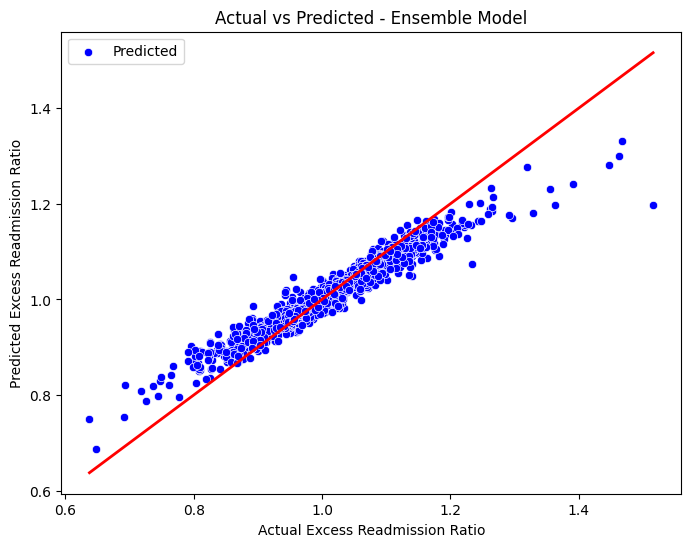

In [ ]:
# Plotting predicted vs actual for Ensemble Model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=ensemble_pred, color="b", label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)
plt.xlabel("Actual Excess Readmission Ratio")
plt.ylabel("Predicted Excess Readmission Ratio")
plt.title("Actual vs Predicted - Ensemble Model")
plt.legend()
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Adjust feature selection to include more features
selector = SelectKBest(f_regression, k=40)

# Slightly increase model complexity while keeping some regularization
mlp = MLPRegressor(hidden_layer_sizes=(30, 20), max_iter=300, alpha=0.005, random_state=42)
xgb = XGBRegressor(n_estimators=75, max_depth=4, learning_rate=0.1, reg_lambda=0.8, reg_alpha=0.8, random_state=42)
catboost = CatBoostRegressor(iterations=75, depth=4, learning_rate=0.1, l2_leaf_reg=2, random_state=42, verbose=0)

# Ensemble with balanced estimators
ensemble_model = VotingRegressor(estimators=[
    ('mlp', mlp),
    ('xgb', xgb),
    ('catboost', catboost)
])

# Pipeline to select features and then fit the ensemble model
pipeline = Pipeline([
    ('feature_selection', selector),
    ('ensemble', ensemble_model)
])

# Fit the pipeline to the training data
pipeline.fit(X_train_scaled, y_train)

# Make predictions with the adjusted ensemble
ensemble_pred = pipeline.predict(X_test_scaled)

# Evaluate the new ensemble model
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
r2 = r2_score(y_test, ensemble_pred)
print(f"Adjusted Ensemble - RMSE: {rmse:.3f}, R^2: {r2:.3f}")


Adjusted Ensemble - RMSE: 0.032, R^2: 0.838


In [ ]:
# Fit each model individually on the training data
mlp.fit(X_train_scaled, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# MLP Model Evaluation
mlp_pred = mlp.predict(X_test_scaled)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))
mlp_r2 = r2_score(y_test, mlp_pred)
mlp_mape = mean_absolute_percentage_error(y_test, mlp_pred)
print(f"MLP - RMSE: {mlp_rmse:.3f}, R^2: {mlp_r2:.3f}, Accuracy: {100 - mlp_mape * 100:.2f}%")

# XGBoost Model Evaluation
xgb_pred = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
print(f"XGBoost - RMSE: {xgb_rmse:.3f}, R^2: {xgb_r2:.3f}, Accuracy: {100 - xgb_mape * 100:.2f}%")

# CatBoost Model Evaluation
catboost_pred = catboost.predict(X_test)
catboost_rmse = np.sqrt(mean_squared_error(y_test, catboost_pred))
catboost_r2 = r2_score(y_test, catboost_pred)
catboost_mape = mean_absolute_percentage_error(y_test, catboost_pred)
print(f"CatBoost - RMSE: {catboost_rmse:.3f}, R^2: {catboost_r2:.3f}, Accuracy: {100 - catboost_mape * 100:.2f}%")


MLP - RMSE: 0.052, R^2: 0.565, Accuracy: 96.73%
XGBoost - RMSE: 0.029, R^2: 0.867, Accuracy: 98.33%
CatBoost - RMSE: 0.039, R^2: 0.758, Accuracy: 97.36%


Adjusted Ensemble - MAPE: 1.914%


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load the dataset
file_path = 'HR/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Replace non-numeric values "Too Few to Report" with NaN
data.replace("Too Few to Report", np.nan, inplace=True)

# Drop irrelevant columns
data_cleaned = data.drop(columns=['Facility Name', 'Footnote', 'Start Date', 'End Date'])

# Drop rows with missing values in critical columns for prediction
data_cleaned = data_cleaned.dropna(subset=['Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate'])

# Convert categorical columns to numeric using one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=['State', 'Measure Name'], drop_first=True)

# Impute all remaining missing values with the median for each column
imputer = SimpleImputer(strategy='median')
data_encoded = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)

# Define a threshold to create binary classification labels
data_encoded['Readmission_Class'] = (data_encoded['Excess Readmission Ratio'] > 1).astype(int)

# Define features and target variable
X = data_encoded.drop(columns=['Excess Readmission Ratio', 'Readmission_Class'])
y = data_encoded['Readmission_Class']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
catboost = CatBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)

# Ensemble model using Voting Classifier
ensemble = VotingClassifier(estimators=[('mlp', mlp), ('xgb', xgb), ('catboost', catboost)], voting='soft')

# Train the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Predict on the test data
ensemble_pred = ensemble.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")


Ensemble Model Accuracy: 90.85%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load the dataset
file_path = 'HR/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Replace non-numeric values "Too Few to Report" with NaN
data.replace("Too Few to Report", np.nan, inplace=True)

# Drop irrelevant columns
data_cleaned = data.drop(columns=['Facility Name', 'Footnote', 'Start Date', 'End Date'])

# Drop rows with missing values in critical columns for prediction
data_cleaned = data_cleaned.dropna(subset=['Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate'])

# Convert categorical columns to numeric using one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=['State', 'Measure Name'], drop_first=True)

# Impute all remaining missing values with the median for each column
imputer = SimpleImputer(strategy='median')
data_encoded = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)

# Define a threshold to create binary classification labels
data_encoded['Readmission_Class'] = (data_encoded['Excess Readmission Ratio'] > 1).astype(int)

# Define features and target variable
X = data_encoded.drop(columns=['Excess Readmission Ratio', 'Readmission_Class'])
y = data_encoded['Readmission_Class']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
catboost = CatBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)

# Ensemble model using Voting Classifier
ensemble = VotingClassifier(estimators=[('mlp', mlp), ('xgb', xgb), ('catboost', catboost)], voting='soft')

# Train the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Predict on training and test data
train_pred = ensemble.predict(X_train)
test_pred = ensemble.predict(X_test)

# Calculate and display accuracy for training and test data
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 93.40%
Test Accuracy: 90.85%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load the dataset
file_path = 'HR/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Replace non-numeric values "Too Few to Report" with NaN
data.replace("Too Few to Report", np.nan, inplace=True)

# Drop irrelevant columns
data_cleaned = data.drop(columns=['Facility Name', 'Footnote', 'Start Date', 'End Date'])

# Drop rows with missing values in critical columns for prediction
data_cleaned = data_cleaned.dropna(subset=['Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate'])

# Convert categorical columns to numeric using one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=['State', 'Measure Name'], drop_first=True)

# Impute all remaining missing values with the median for each column
imputer = SimpleImputer(strategy='median')
data_encoded = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)

# Define a threshold to create binary classification labels
data_encoded['Readmission_Class'] = (data_encoded['Excess Readmission Ratio'] > 1).astype(int)

# Define features and target variable
X = data_encoded.drop(columns=['Excess Readmission Ratio', 'Readmission_Class'])
y = data_encoded['Readmission_Class']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers with reduced complexity
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=300, alpha=0.01, random_state=42)  # Smaller architecture with regularization
xgb = XGBClassifier(n_estimators=50, learning_rate=0.05, reg_lambda=1.0, random_state=42)  # Fewer estimators with regularization
catboost = CatBoostClassifier(n_estimators=50, learning_rate=0.05, l2_leaf_reg=3.0, random_state=42, verbose=0)  # Fewer estimators with regularization

# Ensemble model using hard Voting Classifier
ensemble = VotingClassifier(estimators=[('mlp', mlp), ('xgb', xgb), ('catboost', catboost)], voting='hard')

# Train the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Predict on training and test data
train_pred = ensemble.predict(X_train)
test_pred = ensemble.predict(X_test)

# Calculate and display accuracy for training, test, and ensemble
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 92.32%
Test Accuracy: 90.44%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load the dataset
file_path = 'HR/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Replace non-numeric values "Too Few to Report" with NaN
data.replace("Too Few to Report", np.nan, inplace=True)

# Drop irrelevant columns
data_cleaned = data.drop(columns=['Facility Name', 'Footnote', 'Start Date', 'End Date'])

# Drop rows with missing values in critical columns for prediction
data_cleaned = data_cleaned.dropna(subset=['Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate'])

# Convert categorical columns to numeric using one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=['State', 'Measure Name'], drop_first=True)

# Impute all remaining missing values with the median for each column
imputer = SimpleImputer(strategy='median')
data_encoded = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)

# Define a threshold to create binary classification labels
data_encoded['Readmission_Class'] = (data_encoded['Excess Readmission Ratio'] > 1).astype(int)

# Define features and target variable
X = data_encoded.drop(columns=['Excess Readmission Ratio', 'Readmission_Class'])
y = data_encoded['Readmission_Class']

# Select only a subset of features to reduce complexity
selected_features = X.columns[:10]  # Choosing first 10 features as an example
X = X[selected_features]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers with stronger regularization and reduced complexity
mlp = MLPClassifier(hidden_layer_sizes=(16,), max_iter=200, alpha=0.1, random_state=42)  # Smaller architecture with stronger regularization
xgb = XGBClassifier(n_estimators=30, learning_rate=0.03, max_depth=3, reg_lambda=5.0, random_state=42)  # Reduced complexity with stronger regularization
catboost = CatBoostClassifier(n_estimators=30, learning_rate=0.03, max_depth=3, l2_leaf_reg=5.0, random_state=42, verbose=0)  # Reduced complexity

# Train individual models on the training data and evaluate separately
mlp.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Predict on training and test data with each model
mlp_train_pred = mlp.predict(X_train)
mlp_test_pred = mlp.predict(X_test)

xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

catboost_train_pred = catboost.predict(X_train)
catboost_test_pred = catboost.predict(X_test)

# Calculate and display accuracy for training and test data for each model
mlp_train_accuracy = accuracy_score(y_train, mlp_train_pred)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_pred)
print(f"MLP Training Accuracy: {mlp_train_accuracy * 100:.2f}%")
print(f"MLP Test Accuracy: {mlp_test_accuracy * 100:.2f}%")

xgb_train_accuracy = accuracy_score(y_train, xgb_train_pred)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)
print(f"XGBoost Training Accuracy: {xgb_train_accuracy * 100:.2f}%")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy * 100:.2f}%")

catboost_train_accuracy = accuracy_score(y_train, catboost_train_pred)
catboost_test_accuracy = accuracy_score(y_test, catboost_test_pred)
print(f"CatBoost Training Accuracy: {catboost_train_accuracy * 100:.2f}%")
print(f"CatBoost Test Accuracy: {catboost_test_accuracy * 100:.2f}%")

# Average the individual predictions for a final ensemble prediction (soft-voting)
ensemble_train_pred = (mlp_train_pred + xgb_train_pred + catboost_train_pred) / 3
ensemble_test_pred = (mlp_test_pred + xgb_test_pred + catboost_test_pred) / 3

# Calculate and display accuracy for the ensemble
ensemble_train_accuracy = accuracy_score(y_train, ensemble_train_pred.round())
ensemble_test_accuracy = accuracy_score(y_test, ensemble_test_pred.round())
print(f"Ensemble Training Accuracy: {ensemble_train_accuracy * 100:.2f}%")
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy * 100:.2f}%")


MLP Training Accuracy: 48.72%
MLP Test Accuracy: 47.64%
XGBoost Training Accuracy: 72.63%
XGBoost Test Accuracy: 72.64%
CatBoost Training Accuracy: 71.67%
CatBoost Test Accuracy: 71.73%
Ensemble Training Accuracy: 72.38%
Ensemble Test Accuracy: 72.14%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load the dataset
file_path = 'HR/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Replace non-numeric values "Too Few to Report" with NaN
data.replace("Too Few to Report", np.nan, inplace=True)

# Drop irrelevant columns
data_cleaned = data.drop(columns=['Facility Name', 'Footnote', 'Start Date', 'End Date'])

# Drop rows with missing values in critical columns for prediction
data_cleaned = data_cleaned.dropna(subset=['Excess Readmission Ratio', 'Predicted Readmission Rate', 'Expected Readmission Rate'])

# Convert categorical columns to numeric using one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=['State', 'Measure Name'], drop_first=True)

# Impute all remaining missing values with the median for each column
imputer = SimpleImputer(strategy='median')
data_encoded = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)

# Define a threshold to create binary classification labels
data_encoded['Readmission_Class'] = (data_encoded['Excess Readmission Ratio'] > 1).astype(int)

# Define features and target variable
X = data_encoded.drop(columns=['Excess Readmission Ratio', 'Readmission_Class'])
y = data_encoded['Readmission_Class']

# Select a broader subset of features for training
selected_features = X.columns[:15]  # Using first 15 features to capture more patterns
X = X[selected_features]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers with enhanced configurations
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, alpha=0.001, random_state=42, early_stopping=True)  # Deeper architecture, more regularization
xgb = XGBClassifier(n_estimators=50, learning_rate=0.01, max_depth=4, reg_lambda=3.0, random_state=42)  # Increased complexity
catboost = CatBoostClassifier(n_estimators=50, learning_rate=0.01, max_depth=4, l2_leaf_reg=3.0, random_state=42, verbose=0)  # Enhanced configuration

# Train individual models on the training data
mlp.fit(X_train_scaled, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Predict on training and test data with each model
mlp_train_pred = mlp.predict(X_train_scaled)
mlp_test_pred = mlp.predict(X_test_scaled)

xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

catboost_train_pred = catboost.predict(X_train)
catboost_test_pred = catboost.predict(X_test)

# Calculate and display accuracy for training and test data for each model
mlp_train_accuracy = accuracy_score(y_train, mlp_train_pred)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_pred)
print(f"MLP Training Accuracy: {mlp_train_accuracy * 100:.2f}%")
print(f"MLP Test Accuracy: {mlp_test_accuracy * 100:.2f}%")

xgb_train_accuracy = accuracy_score(y_train, xgb_train_pred)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)
print(f"XGBoost Training Accuracy: {xgb_train_accuracy * 100:.2f}%")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy * 100:.2f}%")

catboost_train_accuracy = accuracy_score(y_train, catboost_train_pred)
catboost_test_accuracy = accuracy_score(y_test, catboost_test_pred)
print(f"CatBoost Training Accuracy: {catboost_train_accuracy * 100:.2f}%")
print(f"CatBoost Test Accuracy: {catboost_test_accuracy * 100:.2f}%")

# Average the individual predictions for a final ensemble prediction (soft-voting)
ensemble_train_pred = (mlp_train_pred + xgb_train_pred + catboost_train_pred) / 3
ensemble_test_pred = (mlp_test_pred + xgb_test_pred + catboost_test_pred) / 3

# Calculate and display accuracy for the ensemble
ensemble_train_accuracy = accuracy_score(y_train, ensemble_train_pred.round())
ensemble_test_accuracy = accuracy_score(y_test, ensemble_test_pred.round())
print(f"Ensemble Training Accuracy: {ensemble_train_accuracy * 100:.2f}%")
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy * 100:.2f}%")


MLP Training Accuracy: 98.33%
MLP Test Accuracy: 97.76%
XGBoost Training Accuracy: 72.69%
XGBoost Test Accuracy: 73.05%
CatBoost Training Accuracy: 71.82%
CatBoost Test Accuracy: 71.90%
Ensemble Training Accuracy: 75.20%
Ensemble Test Accuracy: 75.29%
